In [38]:
pip install idx2numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import os
from turtle import forward
import torch
from torch import TensorType, nn
from os.path import exists
from matplotlib import pyplot as plt
import numpy as np
import torchvision.utils as vutils
import math
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader
import time
import torch.optim as optim

import idx2numpy

def plot_several(data,titles):
    m = data.shape[0]
    print(m)
    fig, axes = plt.subplots(ncols = m,sharex=False, sharey=True, figsize=(10, 4))
    for i in range(m):
        #print(titles[i])
        axes[i].set_title(titles[i])
        axes[i].imshow(data[i,0,:,:], cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    plt.show()

def import_data(imageFile,labelsFile):
    data = idx2numpy.convert_from_file(imageFile)
    # arr is a np.ndarray type of object of shape (60000, 28, 28)
    labels = idx2numpy.convert_from_file(labelsFile)
    # labels is a np.ndarray type of object of shape (60000, )
    data = (torch.tensor(data).float() - 128)/128
    #normalises the data to the interval [-1,1]
    labels = torch.tensor(labels).float()

    dataShape = torch.reshape(data,(-1,1,28,28))
    # We reshape to allow for a channel "1" which makes working with the convolution functions later easier
    #print(data[0,:,:])
    return dataShape, labels

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

def beta_schedule(T,s=0.008):
    # from https://arxiv.org/pdf/2102.09672.pdf pg 4
    steps = T + 1
    x = torch.linspace(0,T,steps)
    alpha = torch.cos(0.5*math.pi*((x/T)+s)/(1+s))**2
    alpha = alpha/alpha[0]
    beta = 1 - (alpha[1:]/(alpha[:-1]))
    return torch.clamp(beta,0.0001,0.9999)
    
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    t = t.type(torch.int64)
    out = a.gather(-1, t.cuda())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# forward diffusion (using the nice property)
def q_sample(x_start, t,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start) #Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )
    #print(sqrt_alphas_cumprod_t,sqrt_one_minus_alphas_cumprod_t)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def p_losses(denoise_model, x_start, t,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod, noise = None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start, t,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod, noise=noise)

    predicted_noise = denoise_model(x_noisy, t)

    loss = F.smooth_l1_loss(noise, predicted_noise) #Creates a criterion that uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than torch.nn.MSELoss and in some cases prevents exploding gradients (e.g. see the paper Fast R-CNN by Ross Girshick).
    return loss

class Encoder(nn.Module):
    def __init__(self,shapeIn,nLatent):
        super(Encoder, self).__init__()
        self.shapeIn = shapeIn
        self.nLatent = nLatent

        self.enc1 = self.encoder_block(1,10,3,2,1)
        self.enc2 = self.encoder_block(10,20,3,2,1)
        self.lin1 = self.linear(980,nLatent)
        self.lin2 = self.linear(980,nLatent)

    def encoder_block(self, input_channel, output_channel, kernel_size, stride, padding):
        return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
                #nn.BatchNorm2d(output_channel),
                nn.ReLU(0.2)#,inplace=True),
            )   

    def linear(self,nIn,nOut):
        return nn.Sequential(
            nn.Linear(nIn,nOut),
            #nn.BatchNorm2d(output_channel),
            nn.ReLU(0.2)#,inplace=True)
        )

    def forward(self,z):
        #print(z.shape)
        z = self.enc1(z)
        #print(z.shape)
        z = self.enc2(z)
        #print(z.shape)
        z = z.view(-1, 7*7*20)
        #print(z.shape)
        mu = self.lin1(z)
        logVar = self.lin2(z)
        #print(mu.shape,logVar.shape)
        return mu, logVar

class Decoder(nn.Module):
    def __init__(self,shapeOut,nLatent):
        super(Decoder, self).__init__()

        self.linear1 = self.linear(nLatent,7*7*20)
        self.dec1 = self.decoder_block(20,10,3,3,2)
        self.dec2 = self.decoder_block(10,1,2,2,3)

    def decoder_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
        return nn.Sequential(
            nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
            #nn.BatchNorm2d(output_channel),
            nn.LeakyReLU(0.2)#,inplace=True),
        )   

    def linear(self,nLatent,nOut):
        return nn.Sequential(
                nn.Linear(nLatent,nOut),
                #nn.BatchNorm2d(output_channel),
                nn.ReLU(0.2)#,inplace=True),
            )

    def forward(self,z):
        #print(z.shape)
        z = self.linear1(z)
        #print(z.shape)
        z = z.view(-1,20,7,7)
        z = self.dec1(z)
        #print(z.shape)
        z = self.dec2(z)
        #print(z.shape)
        return z
    
class Diffusion(nn.Module):
    def __init__(self,shapeIn,nLatent):
        super(Diffusion, self).__init__()

        self.encoder = Encoder(shapeIn,nLatent)
        self.decoder = Decoder(shapeIn,nLatent) 
        # not needed in first instance?
        # self.time_dimen = nn.Sequential(
        #         SinusoidalPositionEmbeddings(dim),
        #         nn.Linear(dim, time_dim),
        #         nn.GELU(),
        #         nn.Linear(time_dim, time_dim),
        #     )

    def reparameterize(self, mu, logVar):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, z, t):
        ### todo - implement time awareness 
        mu,logVar = self.encoder.forward(z)
        z = self.reparameterize(mu, logVar)
        return self.decoder.forward(z)
    

def sample_model(diffusion,x,T,betas,sqrt_recip_alphas,sqrt_one_minus_alphas_cumprod,posterior_variance,device):
    # we want to sample our model to check progress
    def sample_timestep(diffusion,x,t,betas,sqrt_recip_alphas,sqrt_one_minus_alphas_cumprod,posterior_variance,device):
        betas_t = extract(betas,t, x.shape).to(device)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape).to(device)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape).to(device)

        model_mean = sqrt_recip_alphas_t * (x - betas_t * diffusion.forward(x, t) / sqrt_one_minus_alphas_cumprod_t)
        model_mean = model_mean.to(device)
        if t == 0:
            return model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape).to(device)
            noise = torch.randn_like(x).to(device)
            # Algorithm 2 line 4:
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    xt = x
    for t in range(T):
        xt = sample_timestep(diffusion,xt,torch.tensor([t]),betas,sqrt_recip_alphas,sqrt_one_minus_alphas_cumprod,posterior_variance,device)


    return xt


In [56]:

def backpropogate(epochs,dataloader,diffusion,optimiser,steps,losses,T,batch_size,device,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod):
    
    if(len(steps) != 0):
        step = steps[-1]
    else:
        step =0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        for i, data in enumerate(dataloader, 0):
            data=data.to(device)
            steps.append(step)
            step += 1

            optimiser.zero_grad()
            #################
            t = torch.randint(0,T,(batch_size,),device = device)
            loss = p_losses(diffusion,data,t,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod)

            loss.backward()
            optimiser.step()
            losses.append(loss.item())

            if i % 200 == 0:
                print('[%d/%d][%d/%d]\tLoss: %.4f'
              % (epoch, epochs, i, len(dataloader),
                  losses[-1]))
        print('After epoch %i, the loss is %.4f' % (epoch,losses[-1]))

    return diffusion, steps, losses


In [58]:
fileFolder = '/content/drive/MyDrive/Colab Notebooks/train_classifier'

trainingFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
testFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
modelPath = fileFolder + '/diffusion.pt'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
data,numbers = import_data(trainingFiles[0],trainingFiles[1])


T = 200
betas = beta_schedule(T,0.008).to(device)
alphas = 1.-betas
alphas_cumprod = torch.cumprod(alphas,-1) # cumprod is all the products of previous elements
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
plot_noise = False


# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).to(device)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

############### plotting data #############
i = random.randint(0,60000)
x = data[i:i+1].to(device)
xs = x
ts = np.linspace(0,199,5,dtype = int)
for t in ts[1:]:
    x_noise = q_sample(x, torch.tensor([t]).to(device),sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod, noise=None)
    xs = torch.cat((xs,x_noise),0)
if plot_noise:
    plot_several(xs,ts)
##########

diffusion = Diffusion([28,28],100).to(device)

steps = []
losses = []


Using cuda device


In [59]:
batch_size = 128
epochs = 10
learning_rate = 1e-3
data_subset = 60000


dataloader = DataLoader(data[0:data_subset,:,:,:], batch_size=batch_size, shuffle=True, drop_last=True )
optimiser = optim.Adam(diffusion.parameters(), lr=learning_rate)

In [60]:
diffusion, steps, losses = backpropogate(epochs,dataloader,diffusion,optimiser,steps,losses,T,batch_size,device,sqrt_alphas_cumprod,sqrt_one_minus_alphas_cumprod)


[0/10][0/468]	Loss: 0.4262
[0/10][200/468]	Loss: 0.4247
[0/10][400/468]	Loss: 0.4155
After epoch 0, the loss is 0.4134
[1/10][0/468]	Loss: 0.4129
[1/10][200/468]	Loss: 0.4147
[1/10][400/468]	Loss: 0.4106
After epoch 1, the loss is 0.4087
[2/10][0/468]	Loss: 0.4142
[2/10][200/468]	Loss: 0.4098
[2/10][400/468]	Loss: 0.4069
After epoch 2, the loss is 0.4072
[3/10][0/468]	Loss: 0.4086
[3/10][200/468]	Loss: 0.4066
[3/10][400/468]	Loss: 0.4061
After epoch 3, the loss is 0.4092
[4/10][0/468]	Loss: 0.4077
[4/10][200/468]	Loss: 0.4060
[4/10][400/468]	Loss: 0.4065
After epoch 4, the loss is 0.4058
[5/10][0/468]	Loss: 0.4028
[5/10][200/468]	Loss: 0.4047
[5/10][400/468]	Loss: 0.4035
After epoch 5, the loss is 0.4035
[6/10][0/468]	Loss: 0.4047
[6/10][200/468]	Loss: 0.4011
[6/10][400/468]	Loss: 0.4055
After epoch 6, the loss is 0.4045
[7/10][0/468]	Loss: 0.4046
[7/10][200/468]	Loss: 0.4018
[7/10][400/468]	Loss: 0.3991
After epoch 7, the loss is 0.4045
[8/10][0/468]	Loss: 0.4015
[8/10][200/468]	Loss:

2


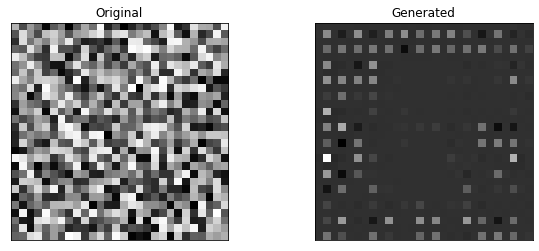

In [61]:

x = torch.rand(1,1,28,28).to(device)
x_samp = sample_model(diffusion,x,T,betas,sqrt_recip_alphas,sqrt_one_minus_alphas_cumprod,posterior_variance,device)
x_out = diffusion.forward(x,0).detach().to('cpu')
x = x.to('cpu')
plot_several(torch.cat((x,x_out),0),["Original","Generated"])